In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Normalize

torch.manual_seed(42)

In [3]:
input_dir = "/kaggle/input/fakefaces"

In [4]:
images = glob.glob(input_dir + "/*")

print(len(images))
print(images[:5])

6400
['/kaggle/input/fakefaces/6234.jpg', '/kaggle/input/fakefaces/1269.jpg', '/kaggle/input/fakefaces/3863.jpg', '/kaggle/input/fakefaces/6241.jpg', '/kaggle/input/fakefaces/623.jpg']


In [5]:
img_size = 128

class CustomDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        image = Image.open(img_name)
        image = image.resize((img_size, img_size))
        image = np.array(image)
        if self.transform:
            image = self.transform(image)
        return image

In [6]:
transform=Compose([
    ToTensor(),
])

In [7]:
training_data = CustomDataset(images, transform=transform)

In [8]:
batch_size = 4

train_dataloader = DataLoader(training_data, batch_size=batch_size)

for X in train_dataloader:
    print(X.shape)
    break

torch.Size([4, 3, 128, 128])


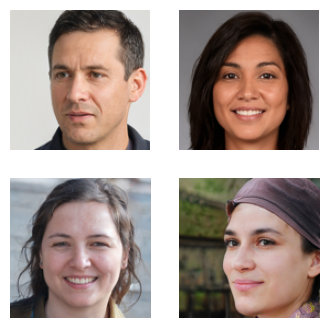

In [9]:
fig = plt.figure(figsize=(4, 4))
columns = 2
rows = 2
for i in range(columns*rows):
    for X in train_dataloader:
        img = X[i]
        img = np.transpose(img, (1, 2, 0))
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(img)
        break

plt.show()

In [10]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = nn.Flatten()
        self.main = nn.Sequential(
            nn.Linear(img_size*img_size*3, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.main(x)
        return x

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_size*img_size*3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [13]:
def plot_images(size=(5, 5)):
    fig = plt.figure(figsize=size)
    columns = 2
    rows = 2
    for i in range(1, columns*rows + 1):
        noise = noise_dist.sample((1, 100)).to(device)
        gen_model.eval()
        img = gen_model(noise)
        img = img.reshape(3, img_size, img_size).cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img)

    plt.show()

In [14]:
gen_model = Generator().to(device)
dis_model = Discriminator().to(device)

In [15]:
gen_optimizer = torch.optim.Adam(gen_model.parameters(), lr=0.00002)
dis_optimizer = torch.optim.Adam(dis_model.parameters(), lr=0.00002)

In [16]:
criterion = nn.BCELoss()
noise_dist = torch.distributions.normal.Normal(0, 1)

In [17]:
def train(num_epochs):

    for epoch in range(num_epochs):

        for i, real_images in enumerate(train_dataloader):
            batch_size = real_images.size(0)

            gen_model.train()

            # Train the Discriminator
            dis_optimizer.zero_grad()
            real_images = real_images.to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train on real images
            real_output = dis_model(real_images)
            dis_real_loss = criterion(real_output, real_labels)

            # Train on fake images
            noise = noise_dist.sample((batch_size, 100)).to(device) 
            fake_images = gen_model(noise)
            fake_output = dis_model(fake_images)
            dis_fake_loss = criterion(fake_output, fake_labels)

            # Backpropagation and optimization
            dis_loss = dis_real_loss + dis_fake_loss
            dis_loss.backward()
            dis_optimizer.step()

            # Train the Generator
            gen_optimizer.zero_grad()
            noise = noise_dist.sample((batch_size, 100)).to(device)
            fake_images = gen_model(noise)
            fake_output = dis_model(fake_images)
            gen_loss = criterion(fake_output, real_labels)

            # Backpropagation and optimization
            gen_loss.backward()
            gen_optimizer.step()

            # Print the losses
            if (i+1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_dataloader)}, dis_loss: {dis_loss.item()}")
                plot_images(size=(3, 3))

Epoch 1/2, Batch 100/1600, dis_loss: 0.3410238027572632


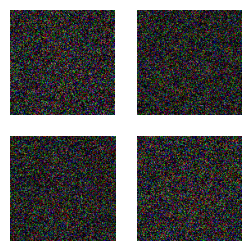

Epoch 1/2, Batch 200/1600, dis_loss: 0.2249499410390854


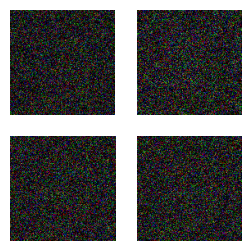

Epoch 1/2, Batch 300/1600, dis_loss: 0.05148937553167343


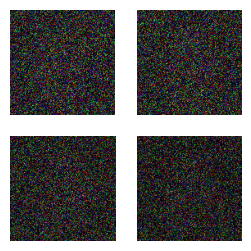

Epoch 1/2, Batch 400/1600, dis_loss: 0.15794217586517334


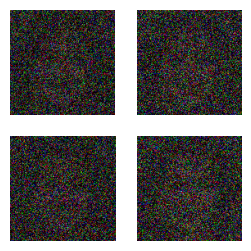

Epoch 1/2, Batch 500/1600, dis_loss: 0.10038329660892487


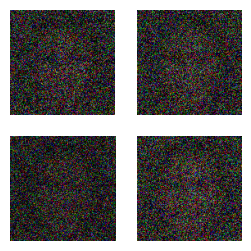

Epoch 1/2, Batch 600/1600, dis_loss: 0.08397197723388672


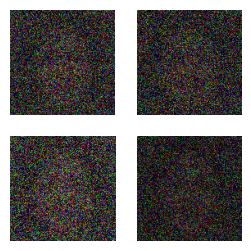

Epoch 1/2, Batch 700/1600, dis_loss: 0.10646620392799377


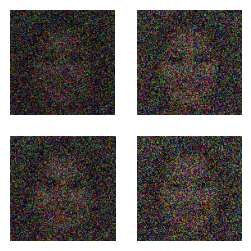

Epoch 1/2, Batch 800/1600, dis_loss: 0.06414303183555603


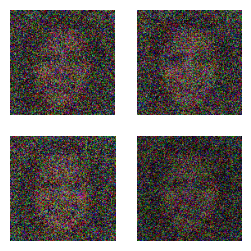

Epoch 1/2, Batch 900/1600, dis_loss: 0.017671290785074234


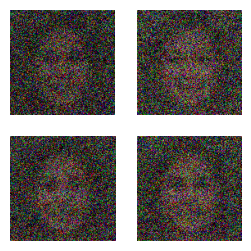

Epoch 1/2, Batch 1000/1600, dis_loss: 0.09883401542901993


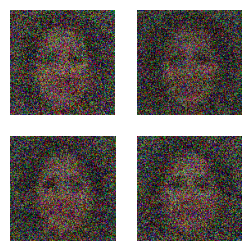

Epoch 1/2, Batch 1100/1600, dis_loss: 0.06213456764817238


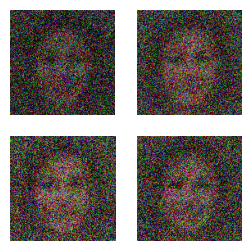

Epoch 1/2, Batch 1200/1600, dis_loss: 0.05194714665412903


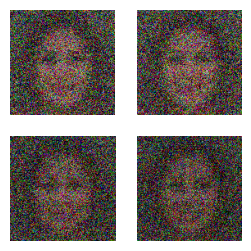

Epoch 1/2, Batch 1300/1600, dis_loss: 0.3694016933441162


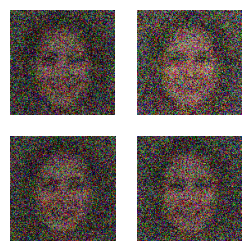

Epoch 1/2, Batch 1400/1600, dis_loss: 0.09632349759340286


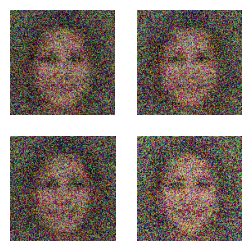

Epoch 1/2, Batch 1500/1600, dis_loss: 0.12861241400241852


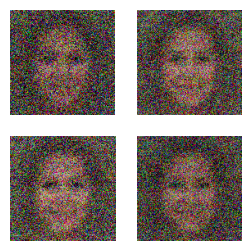

Epoch 1/2, Batch 1600/1600, dis_loss: 0.24220773577690125


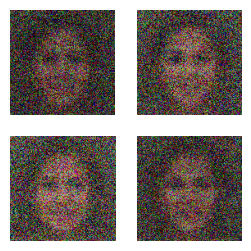

Epoch 2/2, Batch 100/1600, dis_loss: 0.048063989728689194


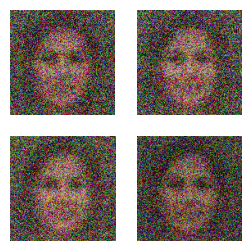

Epoch 2/2, Batch 200/1600, dis_loss: 0.0969957709312439


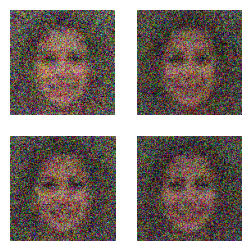

Epoch 2/2, Batch 300/1600, dis_loss: 0.057493895292282104


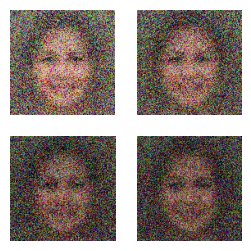

Epoch 2/2, Batch 400/1600, dis_loss: 0.3038402199745178


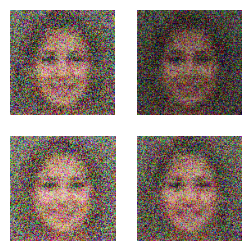

Epoch 2/2, Batch 500/1600, dis_loss: 0.17268958687782288


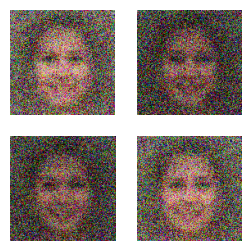

Epoch 2/2, Batch 600/1600, dis_loss: 0.4112711548805237


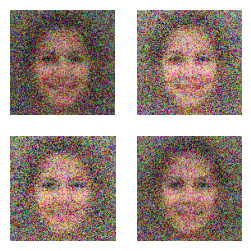

Epoch 2/2, Batch 700/1600, dis_loss: 0.22482414543628693


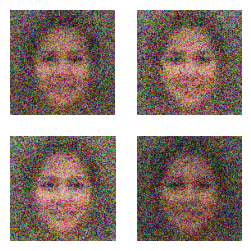

Epoch 2/2, Batch 800/1600, dis_loss: 0.09972208738327026


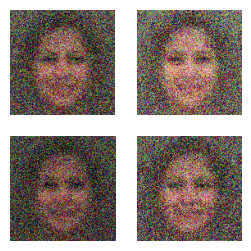

Epoch 2/2, Batch 900/1600, dis_loss: 0.26075494289398193


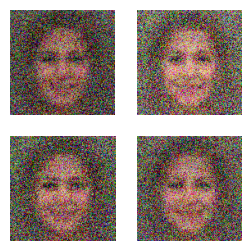

Epoch 2/2, Batch 1000/1600, dis_loss: 0.3664201498031616


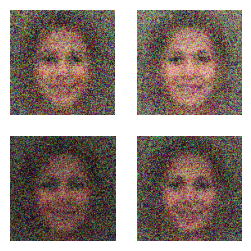

Epoch 2/2, Batch 1100/1600, dis_loss: 0.4446786046028137


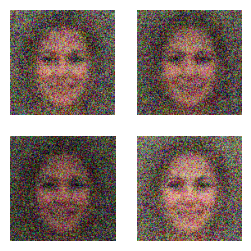

Epoch 2/2, Batch 1200/1600, dis_loss: 0.39197832345962524


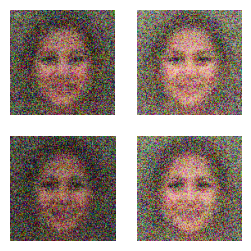

Epoch 2/2, Batch 1300/1600, dis_loss: 0.17219248414039612


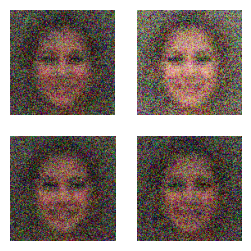

Epoch 2/2, Batch 1400/1600, dis_loss: 0.5572574138641357


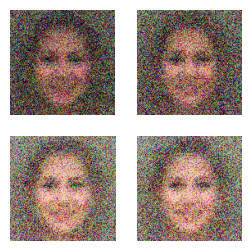

Epoch 2/2, Batch 1500/1600, dis_loss: 0.5945470929145813


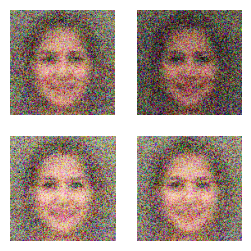

Epoch 2/2, Batch 1600/1600, dis_loss: 0.38679203391075134


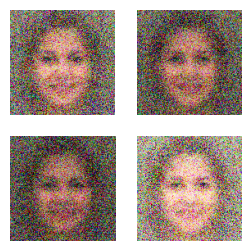

In [18]:
epochs = 2
train(num_epochs=epochs)

In [19]:
torch.save(gen_model.state_dict(), "face_model.pth")

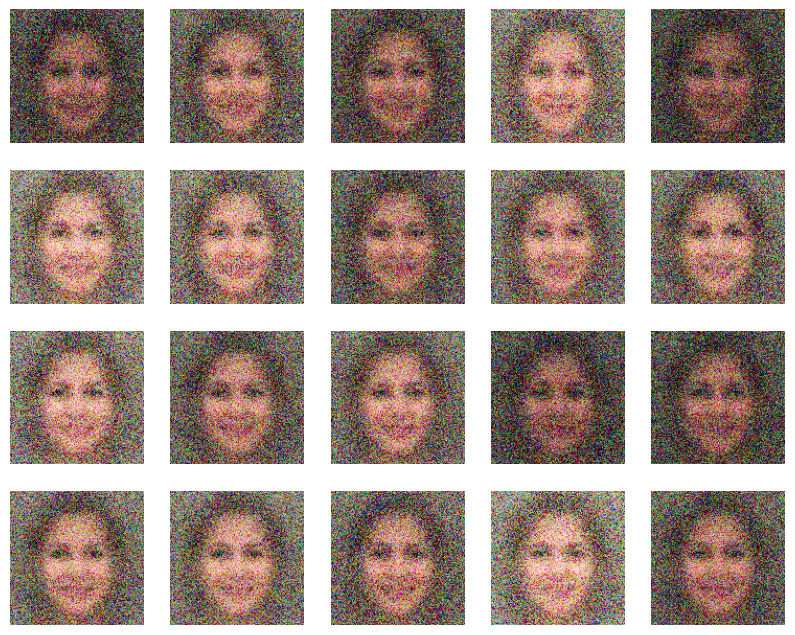

In [20]:
fig = plt.figure(figsize=(10, 8))

noise = noise_dist.sample((20, 100)).to(device)
gen_model.eval()
gen_images = gen_model(noise)

rows = 4
columns = 5

for i in range(gen_images.shape[0]):
    img = gen_images[i].reshape(3, img_size, img_size).cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)

plt.show()